## Import

In [141]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, SimpleRNN, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Pour le prétraitement des textes
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import  stopwords
from nltk.stem.porter import PorterStemmer
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from transformers import BertTokenizer, TFBertModel, pipeline, AutoTokenizer, AutoModelForSequenceClassification
from gensim.models import KeyedVectors

# Pour la séparation des données en ensembles d'entraînement et de test
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

import h5py
import os

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dabereabasse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Define the Problem and Objectives

Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster. 

In this competition, you’re challenged to build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of ``10,000 tweets`` that were hand classified.

### Dataset Description

Each sample in the train set has the following information:

* id - a unique identifier for each tweet
* keyword - a particular keyword from the tweet (may be blank)
* location - the location the tweet was sent from (may be blank)
* text - the text of the tweet
* target - in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

You are predicting whether a given tweet is about a real disaster or not. If so, predict a 1. If not, predict a 0.

### Evaluation:
**Metric:** Submissions are evaluated using ``F1-score`` between the predicted and expected answers

**Submission File Format:**

id,target <br>
0,0 <br>
2,0

## Data Collection

In [2]:
train_data = pd.read_csv('../data/train.csv',index_col='id')
print('train_data shape:', train_data.shape)
train_data.head(5)

train_data shape: (7613, 4)


,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Handling Missing Values

In [3]:
missing_values_count = train_data.isnull().sum()
missing_values_count = missing_values_count[missing_values_count>0]
missing_values_percentage = 100 * missing_values_count/train_data.shape[0]

missing_values_percentage

keyword      0.801261
location    33.272035
dtype: float64

In [4]:
# missing values in keyword and location columns
train_data['keyword'] = train_data['keyword'].fillna('no_keyword')
train_data['location'] = train_data['location'].fillna('no_location')

train_data.head(5)

,keyword,location,text,target
id,,,,
1,no_keyword,no_location,Our Deeds are the Reason of this #earthquake M...,1
4,no_keyword,no_location,Forest fire near La Ronge Sask. Canada,1
5,no_keyword,no_location,All residents asked to 'shelter in place' are ...,1
6,no_keyword,no_location,"13,000 people receive #wildfires evacuation or...",1
7,no_keyword,no_location,Just got sent this photo from Ruby #Alaska as ...,1


### Preprocessing

In [5]:
def preprocess_text(text):
    text_copy = text
    text = text.lower() # Lowercasing
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text) # Remove URLs
    html_pattern = r'<.*?>'
    text = re.sub(html_pattern, '', text) # Remove HTML tags
    punctuation_pattern = r'[^\w\s]'
    text = re.sub(punctuation_pattern, '', text) # Remove punctuation
    number_pattern = r'[0-9]'
    text = re.sub(number_pattern, '', text) # Remove numbers
    stop_words = set(stopwords.words('english'))
    word_tokens = text.split()
    text = ' '.join([word for word in word_tokens if word not in stop_words]) # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    word_tokens = text.split()
    text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens]) # Lemmatization
    if text == '':
        return text_copy
    return text

In [6]:
train_data['text'] = train_data['text'].apply(preprocess_text)
train_data['keyword'] = train_data['keyword'].apply(preprocess_text)
train_data['location'] = train_data['location'].apply(preprocess_text)

train_data.head(5)

,keyword,location,text,target
id,,,,
1,no_keyword,no_location,deed reason earthquake may allah forgive u,1
4,no_keyword,no_location,forest fire near la ronge sask canada,1
5,no_keyword,no_location,resident asked shelter place notified officer ...,1
6,no_keyword,no_location,people receive wildfire evacuation order calif...,1
7,no_keyword,no_location,got sent photo ruby alaska smoke wildfire pour...,1


### Analysing the data

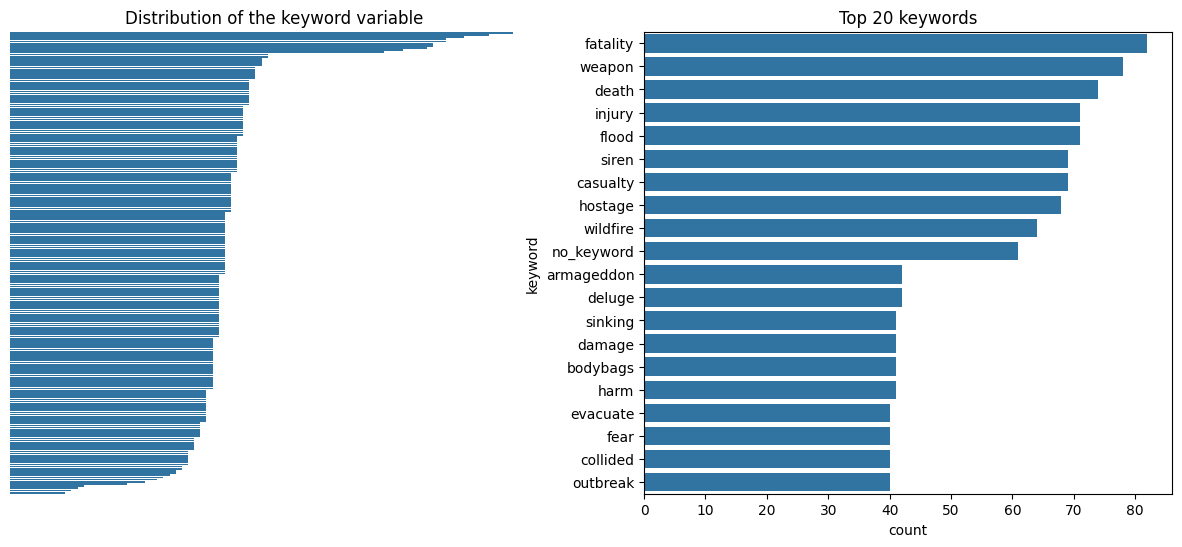

In [7]:
# plot the distribution of the keyword variable
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(y=train_data['keyword'], order = train_data['keyword'].value_counts().index[:])
plt.axis('off')
plt.title('Distribution of the keyword variable')

plt.subplot(1,2,2)
sns.countplot(y=train_data['keyword'], order = train_data['keyword'].value_counts().index[:20])
plt.title('Top 20 keywords')
plt.show()

* keywords are well distributed, need to split body%20bags into body and bags

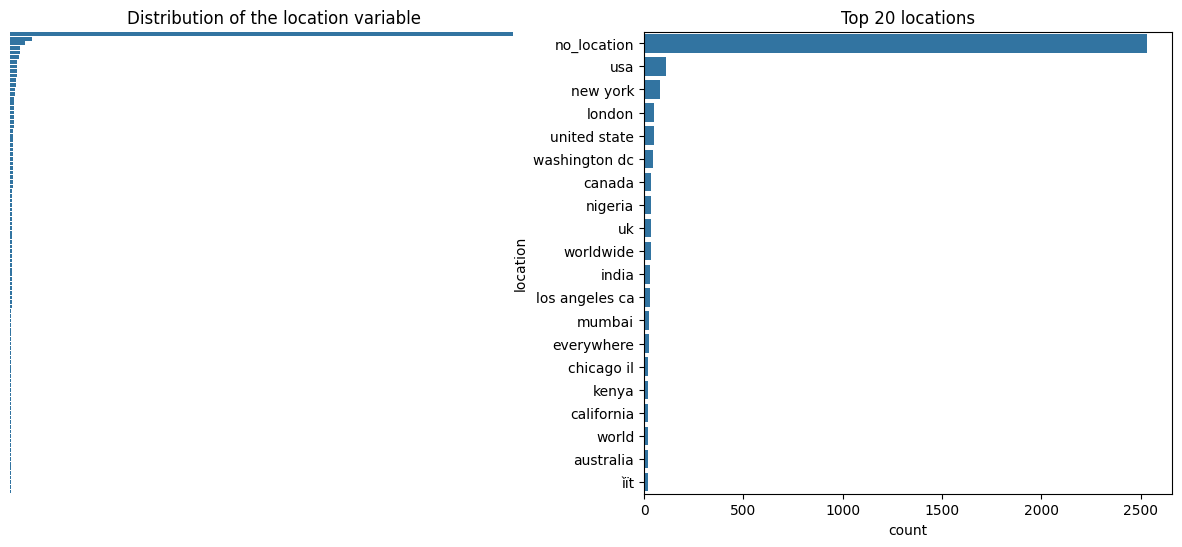

In [8]:
# plot the distribution of the location variable
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
sns.countplot(y=train_data['location'], order = train_data['location'].value_counts().index[:100])
plt.axis('off')
plt.title('Distribution of the location variable')

plt.subplot(1,2,2)
sns.countplot(y=train_data['location'], order = train_data['location'].value_counts().index[:20])
plt.title('Top 20 locations')
plt.show()

In [9]:
# concatenate the keyword and location columns to the text column
X = (train_data['keyword'] + ' ' + train_data['location'] + ' ' + train_data['text']).to_list()
y = train_data['target']

### Embeddings with BERT

In [10]:
# Initialize tokenizer and model
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [11]:
# Function to divide data into mini-batches
def batchify(data, batch_size):
    return [data[i:i + batch_size] for i in range(0, len(data), batch_size)]

# Function to process all sentences in mini-batches
def get_bert_embeddings(sentences, batch_size, max_length):
    embeddings = []
    count = 0
    for batch in batchify(sentences, batch_size):
        count += len(batch)
        print('{}/{}'.format(count, len(sentences)))
        # Tokenize and pad batch
        inputs = bert_tokenizer(batch, padding='max_length', truncation=True, max_length=max_length, return_tensors='tf')
        
        # Get embeddings
        outputs = bert_model(inputs)
        batch_embeddings = outputs.last_hidden_state
        embeddings.append(batch_embeddings)
    
    # Concatenate embeddings from all batches
    return tf.concat(embeddings, axis=0)

In [12]:
# get BERT embeddings for the text data
max_length = max([len(bert_tokenizer.tokenize(sentence)) for sentence in X])
max_length = min(max_length, 512) # BERT cannot process more than 512 tokens at a time

if not os.path.exists('../data/train_bert_embeddings_1.npy'):
    X = get_bert_embeddings(X, batch_size=64, max_length=max_length)
    X = X.numpy()
    np.save('../data/train_bert_embeddings_1.npy', X)
else:
    X = np.load('../data/train_bert_embeddings_1.npy')

In [13]:
# split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (5329, 51, 768)
X_test shape: (2284, 51, 768)


### Helper function

In [14]:
def plot_history(history):
    # plot the training and validation accuracy
    plt.figure(figsize=(15,6))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # plot the training and validation loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

In [15]:
def print_report(y_train, y_train_pred, y_test, y_test_pred):
    print('Training set:')
    print('Accuracy:', accuracy_score(y_train, y_train_pred))
    print('F1 score:', f1_score(y_train, y_train_pred))
    print('Precision:', precision_score(y_train, y_train_pred))
    print('Recall:', recall_score(y_train, y_train_pred))
    print('\n')
    print('Testing set:')
    print('Accuracy:', accuracy_score(y_test, y_test_pred))
    print('F1 score:', f1_score(y_test, y_test_pred))
    print('Precision:', precision_score(y_test, y_test_pred))
    print('Recall:', recall_score(y_test, y_test_pred))

In [28]:
def make_submission(model, file_name='submission.csv'):
    test_data = pd.read_csv('../data/test.csv',index_col='id')
    # handle missing values
    print('Handling missing values...')
    test_data['keyword'] = test_data['keyword'].fillna('no_keyword')
    test_data['location'] = test_data['location'].fillna('no_location')
    # preprocess text
    print('Preprocessing text...')
    test_data['text'] = test_data['text'].apply(preprocess_text)
    test_data['keyword'] = test_data['keyword'].apply(preprocess_text)
    test_data['location'] = test_data['location'].apply(preprocess_text)
    # concatenate the keyword and location columns to the text column
    print('Concatenating the keyword and location columns to the text column...')
    X_submission = (test_data['keyword'] + ' ' + test_data['location'] + ' ' + test_data['text']).to_list()
    # get BERT embeddings for the text data
    print('Getting BERT embeddings for the text data...')
    if not os.path.exists('../data/test_bert_embeddings_1.npy'):
        X_submission = get_bert_embeddings(X_submission, batch_size=64, max_length=max_length)
        X_submission = X_submission.numpy()
        np.save('../data/test_bert_embeddings_1.npy', X_submission)
    else:
        X_submission = np.load('../data/test_bert_embeddings_1.npy')
    n_obs = test_data.shape[0]
    X_submission = X_submission.reshape(model.layers[0].input_shape)
    print('X_submission shape:', X_submission.shape)
    assert X_submission.shape[0] == n_obs
    # make predictions
    print('Making predictions...')
    y_submission = model.predict(X_submission)
    y_submission = (y_submission > 0.5).astype(int)
    # create submission file
    print('Creating submission file...')
    submission = pd.DataFrame({'id': test_data.index, 'target': y_submission.flatten()})
    submission.to_csv('../submissions/'+file_name, index=False)
    print('Submission file created successfully!')

### CNN Model

In [47]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])

In [57]:
# create a CNN model
cnn_model = Sequential(
    [
        keras.layers.Input(shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])),
        keras.layers.Conv1D(64, 3, activation='relu'),
        keras.layers.MaxPooling1D(2),
        keras.layers.Conv1D(128, 3, activation='relu'),
        keras.layers.MaxPooling1D(2),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='sigmoid'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ], name = 'cnn_model_2'
)

# compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
# train the model
cnn_history = cnn_model.fit(X_train_reshaped, y_train, epochs=30, batch_size=64, validation_data=(X_test_reshaped, y_test))

Epoch 1/30
84/84 [==============================] - 2s 22ms/step - loss: 0.5637 - accuracy: 0.7266 - val_loss: 0.4656 - val_accuracy: 0.8034
Epoch 2/30
84/84 [==============================] - 1s 16ms/step - loss: 0.4882 - accuracy: 0.7930 - val_loss: 0.4683 - val_accuracy: 0.7903
Epoch 3/30
84/84 [==============================] - 1s 16ms/step - loss: 0.4474 - accuracy: 0.8090 - val_loss: 0.4514 - val_accuracy: 0.8078
Epoch 4/30
84/84 [==============================] - 1s 16ms/step - loss: 0.4246 - accuracy: 0.8169 - val_loss: 0.4497 - val_accuracy: 0.8060
Epoch 5/30
84/84 [==============================] - 1s 17ms/step - loss: 0.3890 - accuracy: 0.8399 - val_loss: 0.4402 - val_accuracy: 0.8157
Epoch 6/30
84/84 [==============================] - 1s 15ms/step - loss: 0.3635 - accuracy: 0.8512 - val_loss: 0.4441 - val_accuracy: 0.8078
Epoch 7/30
84/84 [==============================] - 1s 16ms/step - loss: 0.3217 - accuracy: 0.8748 - val_loss: 0.6027 - val_accuracy: 0.7846
Epoch 8/30
84

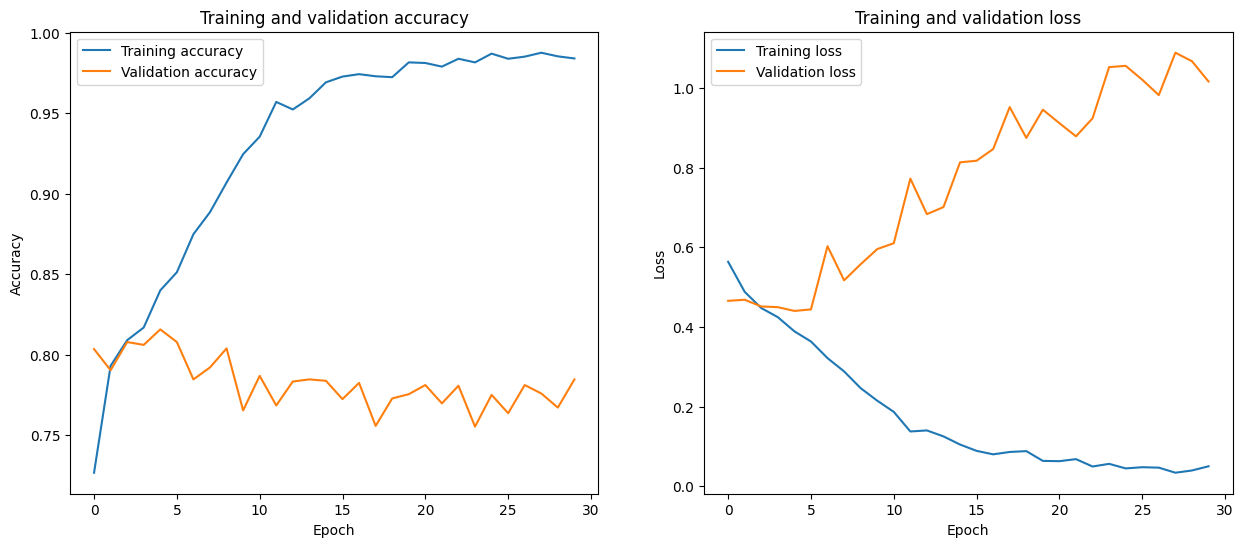

In [59]:
# plot the history
plot_history(cnn_history)

In [46]:
# make predictions
## training set
y_train_pred = cnn_model.predict(X_train_reshaped)
y_train_pred = (y_train_pred > 0.5).astype(int)

## testing set
y_test_pred = cnn_model.predict(X_test_reshaped)
y_test_pred = (y_test_pred > 0.5).astype(int)

# print the classification report
print_report(y_train, y_train_pred, y_test, y_test_pred)

72/72 [==============================] - 6s 81ms/step
Training set:
Accuracy: 0.8065303058735223
F1 score: 0.773655323819978
Precision: 0.7831111111111111
Recall: 0.7644251626898048


Testing set:
Accuracy: 0.782399299474606
F1 score: 0.747843734145104
Precision: 0.7333333333333333
Recall: 0.7629399585921325


#### CNN Model 1

In [17]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# load the model
cnn_model = keras.models.load_model('../models/cnn_model_1.h5')

# compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 49, 766, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 383, 32)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 381, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 190, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 9, 188, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 94, 128)        0

In [18]:
# make predictions
## training set
y_train_pred = cnn_model.predict(X_train_reshaped)
y_train_pred = (y_train_pred > 0.5).astype(int)

## testing set
y_test_pred = cnn_model.predict(X_test_reshaped)
y_test_pred = (y_test_pred > 0.5).astype(int)

# print the classification report
print_report(y_train, y_train_pred, y_test, y_test_pred)

72/72 [==============================] - 6s 81ms/step
Training set:
Accuracy: 0.848001501219741
F1 score: 0.8280254777070064
Precision: 0.8108108108108109
Recall: 0.8459869848156182


Testing set:
Accuracy: 0.776707530647986
F1 score: 0.750733137829912
Precision: 0.7111111111111111
Recall: 0.7950310559006211


In [19]:
# make submission
make_submission(cnn_model, file_name='cnn_model_1_submission.csv')

Handling missing values...
Preprocessing text...
Concatenating the keyword and location columns to the text column...
Getting BERT embeddings for the text data...
X_submission shape: (3263, 51, 768)
Making predictions...
102/102 [==============================] - 8s 80ms/step
Creating submission file...
Submission file created successfully!


### RNN Model

In [ ]:
# create the model
rnn_model = Sequential([
    LSTM(32, return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1, activation='sigmoid')
])

# compile the model
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model summary
rnn_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 32)                102528    
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 102561 (400.63 KB)
Trainable params: 102561 (400.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# callback to print loss, accuracy, val_loss and val_accuracy at each 10 epochs
class printLogs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch % 10 == 0:
            print('epoch: {}, loss: {:.3f}, accuracy: {:.3f}, val_loss: {:.3f}, val_accuracy: {:.3f}'.format(
                epoch, logs['loss'], logs['accuracy'], logs['val_loss'], logs['val_accuracy']
            ))

In [ ]:
# Train the model
history = rnn_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=64)

Epoch 1/10
84/84 [==============================] - 5s 47ms/step - loss: 0.5047 - accuracy: 0.7649 - val_loss: 0.4683 - val_accuracy: 0.7951
Epoch 2/10
84/84 [==============================] - 2s 27ms/step - loss: 0.4393 - accuracy: 0.8024 - val_loss: 0.4533 - val_accuracy: 0.8021
Epoch 3/10
84/84 [==============================] - 2s 24ms/step - loss: 0.4092 - accuracy: 0.8178 - val_loss: 0.4497 - val_accuracy: 0.8025
Epoch 4/10
84/84 [==============================] - 2s 25ms/step - loss: 0.3830 - accuracy: 0.8354 - val_loss: 0.4475 - val_accuracy: 0.8025
Epoch 5/10
84/84 [==============================] - 2s 25ms/step - loss: 0.3576 - accuracy: 0.8439 - val_loss: 0.4594 - val_accuracy: 0.8047
Epoch 6/10
84/84 [==============================] - 2s 26ms/step - loss: 0.3258 - accuracy: 0.8625 - val_loss: 0.4690 - val_accuracy: 0.7933
Epoch 7/10
84/84 [==============================] - 2s 25ms/step - loss: 0.3064 - accuracy: 0.8692 - val_loss: 0.4796 - val_accuracy: 0.7942
Epoch 8/10
84

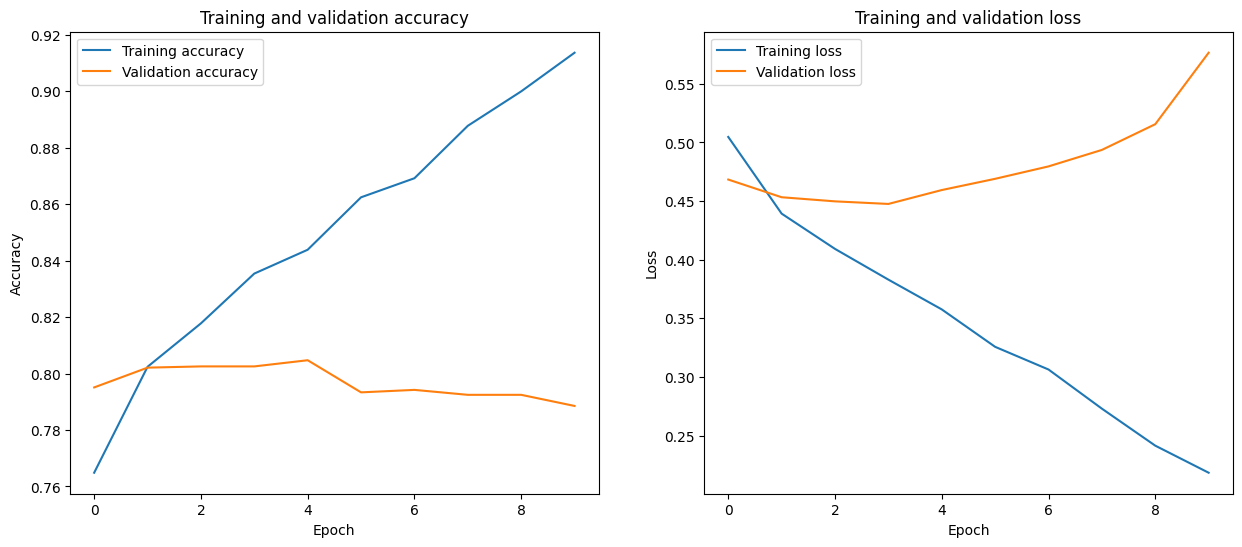

In [ ]:
# plot the training and validation accuracy
plt.figure(figsize=(15,6))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# plot the training and validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

### DNN Model

In [71]:
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1] * X_train.shape[2])
X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1] * X_test.shape[2])

print('X_train_reshaped shape:', X_train_reshaped.shape)
print('X_test_reshaped shape:', X_test_reshaped.shape)

X_train_reshaped shape: (5329, 39168)
X_test_reshaped shape: (2284, 39168)


In [75]:
# pca to keep 95% of the variance
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_reshaped)
X_test_pca = pca.transform(X_test_reshaped)

print('X_train_pca shape:', X_train_pca.shape)
print('X_test_pca shape:', X_test_pca.shape)

X_train_pca shape: (5329, 3109)
X_test_pca shape: (2284, 3109)


In [101]:
# scale the data
scaler = StandardScaler()
X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

In [108]:
# create a dnn model
dnn_model = Sequential(
    [
        keras.layers.Input(shape=(X_train_pca_scaled.shape[1])),
        keras.layers.Dense(256, activation='leaky_relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(64, activation='leaky_relu'),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid')
    ], name = 'dnn_model_1'
)

# compile the model
dnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [109]:
# train the model
dnn_history = dnn_model.fit(X_train_pca_scaled, y_train, epochs=10, batch_size=64, validation_data=(X_test_pca_scaled, y_test))

Epoch 1/10
84/84 [==============================] - 0s 3ms/step - loss: 0.9245 - accuracy: 0.5543 - val_loss: 0.6130 - val_accuracy: 0.6699
Epoch 2/10
84/84 [==============================] - 0s 3ms/step - loss: 0.5619 - accuracy: 0.7099 - val_loss: 0.5550 - val_accuracy: 0.7452
Epoch 3/10
84/84 [==============================] - 0s 3ms/step - loss: 0.3698 - accuracy: 0.8401 - val_loss: 0.5569 - val_accuracy: 0.7566
Epoch 4/10
84/84 [==============================] - 0s 3ms/step - loss: 0.2554 - accuracy: 0.8947 - val_loss: 0.6010 - val_accuracy: 0.7601
Epoch 5/10
84/84 [==============================] - 0s 3ms/step - loss: 0.1888 - accuracy: 0.9298 - val_loss: 0.6501 - val_accuracy: 0.7609
Epoch 6/10
84/84 [==============================] - 0s 2ms/step - loss: 0.1473 - accuracy: 0.9439 - val_loss: 0.7219 - val_accuracy: 0.7566
Epoch 7/10
84/84 [==============================] - 0s 2ms/step - loss: 0.1171 - accuracy: 0.9572 - val_loss: 0.7969 - val_accuracy: 0.7518
Epoch 8/10
84/84 [==

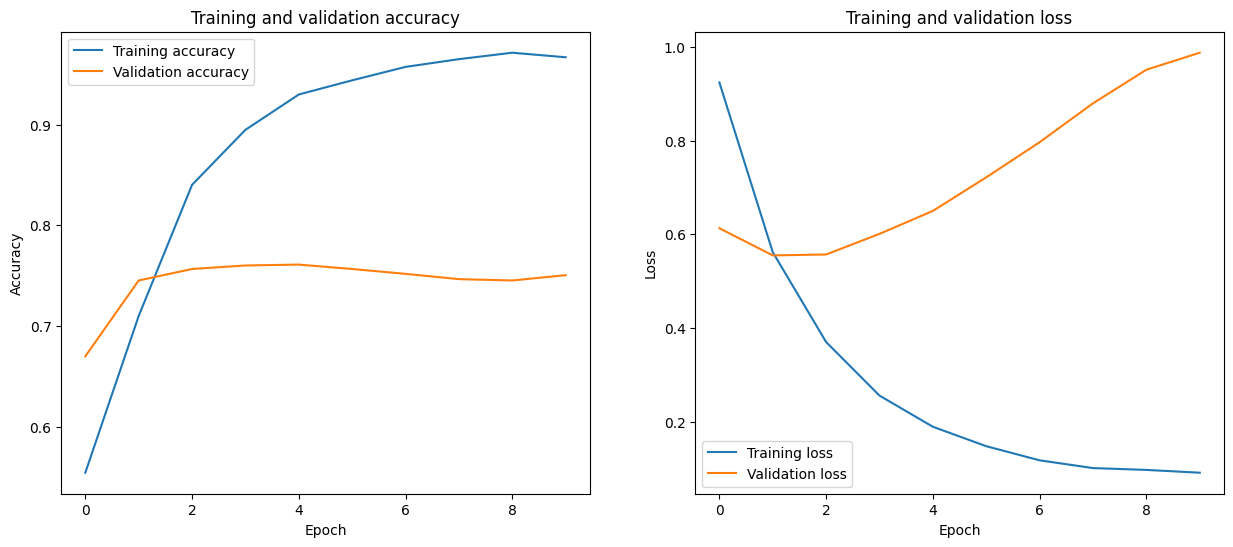

In [110]:
# plot the history
plot_history(dnn_history)